In [1]:
### Start of the Project


In [2]:
### Importing Libraries 

In [3]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
### 1. Load the dataset

In [5]:
# Load files into a pandas dataframe
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')
ss = pd.read_csv('data/SampleSubmission.csv')
variables = pd.read_csv('data/VariableDefinitions.csv')

In [6]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [7]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [8]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


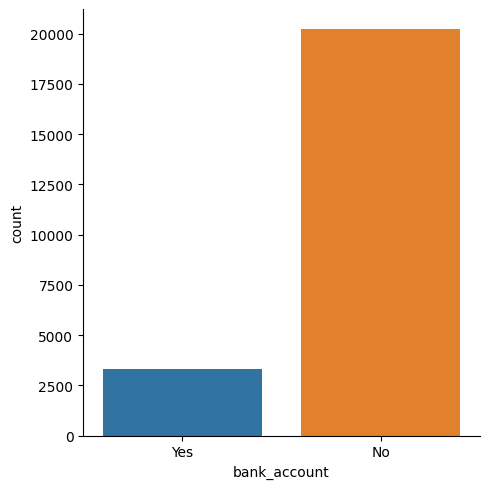

In [9]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

In [10]:
# view the submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [11]:
### 2. Understand the dataset

In [12]:
 #show some information about the dataset
 print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [13]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [14]:
### 3. Data preparation for machine learning

In [15]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Cobvert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


In [16]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be converted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
    return data    

In [17]:
# preprocess the train data 
processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(test)

In [18]:
# the first train row
print(processed_train[:1])

   year  location_type  cellphone_access  household_size  age_of_respondent   
0   1.0            0.0               1.0             0.1           0.095238  \

   gender_of_respondent  relationship_with_head_Child   
0                   0.0                           0.0  \

   relationship_with_head_Head of Household   
0                                       0.0  \

   relationship_with_head_Other non-relatives   
0                                         0.0  \

   relationship_with_head_Other relative  ...  job_type_Government Dependent   
0                                    0.0  ...                            0.0  \

   job_type_Informally employed  job_type_No Income  job_type_Other Income   
0                           0.0                 0.0                    0.0  \

   job_type_Remittance Dependent  job_type_Self employed  country_Kenya   
0                            0.0                     1.0            1.0  \

   country_Rwanda  country_Tanzania  country_Uganda  
0        

In [19]:
# shape of the processed train set
print(processed_train.shape)

(23524, 37)


In [20]:
# Split train_data
from sklearn.model_selection import GridSearchCV, train_test_split 

X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train, 
                                                  test_size = 0.1, random_state=42)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define preprocessing for numerical columns (scale them)
num_cols = ["household_size", "age_of_respondent", "year"]
num_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define preprocessing for categorical columns (one-hot encode them)
cat_cols = ['year', 'location_type', 'cellphone_access', 'household_size',
       'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head_Child',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other non-relatives',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Divorced/Seperated', 'marital_status_Dont know',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_No formal education',
       'education_level_Other/Dont know/RTA',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Dont Know/Refuse to answer', 'job_type_Farming and Fishing',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed', 'country_Kenya', 'country_Rwanda',
       'country_Tanzania', 'country_Uganda']
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Define the model 
model = RandomForestClassifier()

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Fit the pipeline to train data
pipeline.fit(X_Train, y_Train)

# Get predictions on validation data
y_pred = pipeline.predict(X_Val)





In [29]:
# Print classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2022
           1       0.57      0.38      0.45       331

    accuracy                           0.87      2353
   macro avg       0.74      0.67      0.69      2353
weighted avg       0.86      0.87      0.86      2353



In [30]:
# Print confusion matrix
print(confusion_matrix(y_val, y_pred))

[[1928   94]
 [ 206  125]]


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# import decisiontree, knn

# Define the model 
model = RandomForestClassifier()

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Define the parameter grid for the random forest
param_grid = {
    #'model__n_estimators': [100, 200, 300],
    #'model__max_depth': [None, 5, 10],
    #'model__min_samples_split': [2, 5, 10],
    'model': [DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]
}


# mehr Modelle einfügen

# Create the grid search object
gscv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5, 
    n_jobs=-1,
    verbose=1,
    error_score='raise'  # Raise error immediately if a fit fails
)

# Fit the grid search object to the data
gscv.fit(X_Train, y_Train)

# Print the best parameters and the best score
print('Best parameters:', gscv.best_params_)
print('Best score:', gscv.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'model': RandomForestClassifier()}
Best score: 0.8756318530097893


In [35]:
#%timeit gscv.fit(X_train,y_train)

In [36]:
gscv.best_params_
round(gscv.best_score_,6)
best_model = gscv.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['household_size',
                                                   'age_of_respondent',
                                                   'year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['year', 'location_type',
                                                   'cellphone_access',
                                                   'household_size',
                                                   'age_of_respondent',
                                                   'gender_of_respondent',
                                                   'relations...
                                                   'education_level_Tertiary '
                                                   'education',
                                                   'education_level_Vocational/Specialised '
                                                   'training',
                                                   'job_type_Dont Know/Refuse '
                                                   'to answer',
                                                   'job_type_Farming and '
                                                   'Fishing',
                                                   'job_type_Formally employed '
                                                   'Government',
                                                   'job_type_Formally employed '
                                                   'Private',
                                                   'job_type_Government '
                                                   'Dependent',
                                                   'job_type_Informally '
                                                   'employed',
                                                   'job_type_No Income', ...])])),
                ('model', RandomForestClassifier())])

In [ ]:
# Error analysis

In [27]:
print(processed_train.columns)

Index(['year', 'location_type', 'cellphone_access', 'household_size',
       'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head_Child',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other non-relatives',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Divorced/Seperated', 'marital_status_Dont know',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_No formal education',
       'education_level_Other/Dont know/RTA',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Dont Know/Refuse to answer', 'job_type_Farming and Fishing',
       'job_type_Formally employed Government',
       'jo

In [ ]:
### BIS HIERHIN KLAPPT ALLES

In [ ]:
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_Train,y_Train)

In [ ]:
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
xg_y_model = xg_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_model))

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# Get confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(xg_model,X_Val, y_val,normalize='true')

In [ ]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Optimize model parameters
# I run this code in google colab to make the execution much faster and use the best params in the next code
param_grid = {'min_child_weighth': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
my_xgb_model = GridSearchCV(xg_model, param_grid,n_jobs=-1,verbose=2,cv=5)
my_xgb_model.fit(X_Train, y_Train)
print(my_xgb_model.best_params_)        

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# fit by setting best parameters and Evaluate model
xgb_model = XGBClassifier(min_child_weight=1, gamma=1, subsample=0.8, max_depth=5)

xgb_model.fit(X_Train, y_Train)
y_pred = xgb_model.predict(X_Val)

# Get error rate
print("Error rate of the XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

In [ ]:
# Get the predicted result for the test Data
test.bank_account = xgb_model.predict(processed_test)